<h1><center><br>Binary Classification with Logistic Regression<br></center></h1>

# Overview

In this project, logistic regression is implemented from scratch using a subset of the famous handwritten digit dataset called MNIST. In the subset, there are images of digit 1 and 5. Therefore, it is a binary classification problem. The project includes feature extraction, model training, and evaluation steps.

## Feature Extraction 

Train and test data are loaded as numpy arrays.Train and test data are 1561x256 and 424x256 dimensional matrices, respectively. The 256 pixels correspond to a 16x16 image. Label 1 is assigned to digit 1 and label -1 is assigned to digit 5.

In [15]:
import numpy as np
import matplotlib.pyplot as plt

#import training and test data
test_data = np.load('test_data.npy')
test_labels = np.load('test_labels.npy')
train_data = np.load('train_data.npy')
train_labels = np.load('train_labels.npy')


Two of the digit images are displayed, one for digit 1 and one for digit 5. Pixels are reshaped to 16x16 matrix for this purpose. 

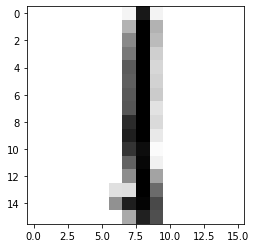

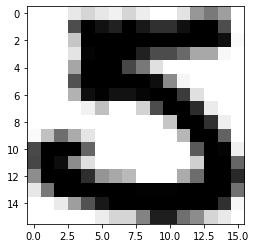

In [2]:
#Reshape train data to 16x16
train_data_16x16 = np.reshape(train_data, (1561,16,16))

#Reshape test data to 16x16
test_data_16x16 = np.reshape(test_data, (424,16,16))

#Display digit 1
i = 0
while (i < 1561):
    i+=1
    if (train_labels[i,] == 1):
        plt.imshow(train_data_16x16[i,:,:], cmap=plt.cm.gray_r, interpolation='nearest')
        plt.show()
        break
        
#Display digit 5
i = 0       
while (i < 1561):
    i+=1
    if (train_labels[i,] == -1):
        plt.imshow(train_data_16x16[i,:,:], cmap=plt.cm.gray_r, interpolation='nearest')
        plt.show()
        break

**Symmetry** and **Average intensity** features are extracted. Average intensity feature is the average pixel value of the image. Symmetry feature is the negative of the norm of the difference between the image and its y-axis symmetrical.

In [3]:
def feature_extraction(data, data_16x16):
    n = len(data)
    avg_intensity = np.mean(data, axis=1).reshape(n,1)
    diff = data_16x16 - np.fliplr(data_16x16)
    symmetry = - np.linalg.norm(diff, axis=(1,2)).reshape(n,1)
    return avg_intensity, symmetry

avg_intensity_train, symmetry_train = feature_extraction(train_data, train_data_16x16)
train_data_extracted = np.hstack((avg_intensity_train,symmetry_train))

avg_intensity_test, symmetry_test = feature_extraction(test_data, test_data_16x16)
test_data_extracted = np.hstack((avg_intensity_test,symmetry_test))

Datasets are visualized using scatter plots, where blue marker shaped <font color='blue'>o</font> represents data points with label ‘1’ and red marker shaped <font color='red'>x</font> represents data point with label ‘5’.
In the scatter plots, even though there are some outliers, data can be clearly separated with respect to the labels ‘1’ and ‘5’, both in the training and test sets.

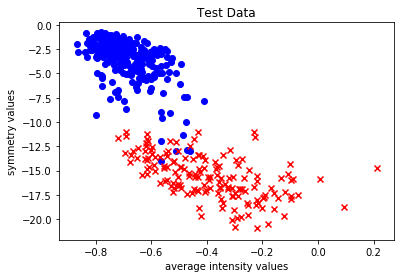

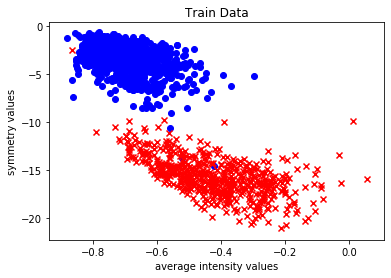

In [4]:
def visualize(avg_intensity, symmetry, labels, title):
    plt.title(title)
    plt.xlabel('average intensity values')
    plt.ylabel('symmetry values')
    plt.scatter(avg_intensity[labels == 1], symmetry[labels == 1], marker='o', c='blue')
    plt.scatter(avg_intensity[labels == -1], symmetry[labels == -1], marker='x', c='red')
    plt.show() 

#Visualize the test data
visualize(avg_intensity_test, symmetry_test, test_labels, 'Test Data')

#Visualize the train data
visualize(avg_intensity_train, symmetry_train, train_labels, 'Train Data')

## Logistic Regression 

<p>In this section, logistic regression is implemented. Firstly, 1 is concatenated to the features for the intercept term, such that one data point will look like for 2-D features [1,$x_1$,$x_2$], and the model vector will be [$w_0, w_1, w_2$], where $w_0$ is the intercept parameter. Then, logistic regression is applied to the training sets with the learning rate of 0.05. To decide when to terminate the gradient descent iterations, the absolute difference between the current loss value and the loss value of the previous step is checked.</p>

Logistic regression function works according to the below learning algorithm: 
<ol>
<li>Initialize weight vector to 0</li>
<li>Compute the gradient$^{(b)}$</li>
<li>Record the current loss value$^{(a)}$</li>
<li>Move in the negative of the gradient direction</li>
<li>Update the weights:<br>
$w(t+1)  = w(t)+\eta v_{t}$ 
</li>
<li>Iterate until the difference between the current loss value and the loss value of the previous step is less than $10^{-5}$ </li>
<li>After iteration, return the learned weights and training loss records</li>
</ol>

Loss value at each iteration is recorded to create a convergence plot. As number of iterations increases, loss value converges to zero.

img/Logistic Loss

![title](gradient.PNG)

In [4]:
#Concatenate 1 to data
X_train = np.append(np.ones((1561,1)),train_data_extracted,axis=1)
X_test = np.append(np.ones((424,1)),test_data_extracted,axis=1)

#Compute sigmoid
def sigmoid(s):
    return 1 / (1 + np.exp(-s))

#Compute the logistic loss
def compute_loss(y_train,X_train,weights):
    loss = 0
    for j in range(0,len(y_train)):
        loss += np.log(1+np.exp(-y_train[j]*weights.T @ X_train[j,:]))                                  
    return (1/len(y_train))*loss

#Compute the gradient
def compute_gradient(y_train,X_train,weights):
    ein_w = 0
    for j in range(0,len(y_train)):
        ein_w += (y_train[j]*X_train[j,:])*sigmoid(-y_train[j]*weights.T @ X_train[j,:]) 
    return -(1/len(y_train)*ein_w )

#Perform logistic regression and keep the loss values at each gradient descent
def log_regression(y_train, X_train, learning_rate, lambda_, return_loss):
    w0,w1,w2 = 0,0,0
    weights = np.array([[w0],[w1],[w2]])
    w_star = []
    training_loss = []
    t = 0
    while(t < 2 or (np.absolute(training_loss[-1] - training_loss[-2]) > 10**(-5))):
        t+=1
        ein_w = compute_gradient(y_train,X_train,weights)
        training_loss.append(compute_loss(y_train,X_train,weights))
        v_t = -ein_w
        weights = weights + learning_rate*(np.asarray(v_t).reshape(3,1)-(lambda_*weights))     
    w_star.append(weights)
    if (return_loss == True): 
        return w_star, training_loss
    else:
        return w_star

#Display convergence
def plot_convergence(training_loss, title):
    plt.figure(figsize=(15,5))
    plt.plot(range(len(training_loss)), training_loss, color='red')
    plt.title(title)
    plt.xlabel("Number of Iterations")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()

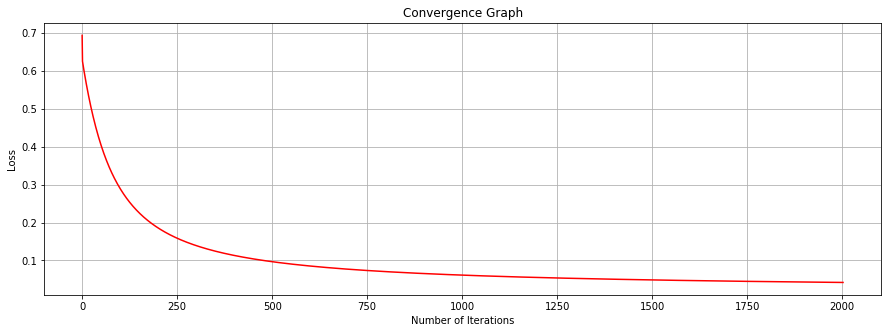

In [6]:
#Perform logistic regression with the learning rate 0.05 without regularization and plot convergence
w_star,training_loss = log_regression(train_labels, X_train, 0.05, 0, True)
plot_convergence(training_loss,'Convergence Graph')

Model is trained with 5 different learning rates and another convergence plot is made showing the effects of these learning rates.

In [ ]:
#Compare different learning rates
def plot_different_learning_rates(y_train, X_train, learning_rates, title):
    plt.figure(figsize=(15,5))
    plt.title(title)
    plt.xlabel("Number of Iterations")
    plt.ylabel("Loss")
    for i in range(0,5):
        training_loss = []
        w0,w1,w2 = 0,0,0
        weights = np.array([[w0],[w1],[w2]])
        for t in range(0,600):
            ein_w = compute_gradient(y_train,X_train,weights)
            training_loss.append(compute_loss(y_train,X_train,weights))
            v_t = -ein_w
            weights = weights + np.asarray(learning_rates[i,]*v_t).reshape(3,1)
        plt.plot(range(len(training_loss)), training_loss, label=learning_rates[i,])
    plt.legend()
    plt.grid()
    plt.show()
    
#Plot the convergence curves for 5 learning rates in the same plot  
learning_rates = np.array([[0.15],[0.1],[0.03],[0.01],[0.001]])

plot_different_learning_rates(train_labels, X_train, learning_rates, "Convergence Graph")

With the learning rate 0.1, loss values converge more quickly. When learning rate is higher than 0.1, we see jumps on the plot. When it is lower than 0.1, convergence takes much more time. That is why, the learning rate 0.1 is chosen to train the model. 

Logistic regression with $\ell_2$ norm regularization, $||\mathbf{w}||_{2}^{2}$, is implemented in order to control overfitting.Regularized logistic regression works according to the below learning algorithm: 
<ol>
<li>Initialize weight vector to 0</li>
<li>Compute the gradient$^{(b)}$</li>
<li>Record the current loss value$^{(a)}$</li>
<li>Move in the negative of the gradient direction</li>
<li>Update the weights:$^{(c)}$<br>
$w(t+1)  = w(t)+\eta (v_{t}-\lambda w)$ 
</li>
<li>Iterate until the difference between the current loss value and the loss value of the previous step is less than $10^{-5}$ </li>
<li>After iteration, return the learned weights and training loss records</li>
</ol>

Loss value at each iteration is recorded to create a convergence plot. As number of iterations increases, loss value converges to zero.

![title](re.PNG)

In [8]:
#Perform regularized logistic regression to Representation 1 with the learning rate 0.1 and lambda 0.01
w_star_reg, training_loss_reg = log_regression(train_labels, X_train, 0.1, 0.01, True)

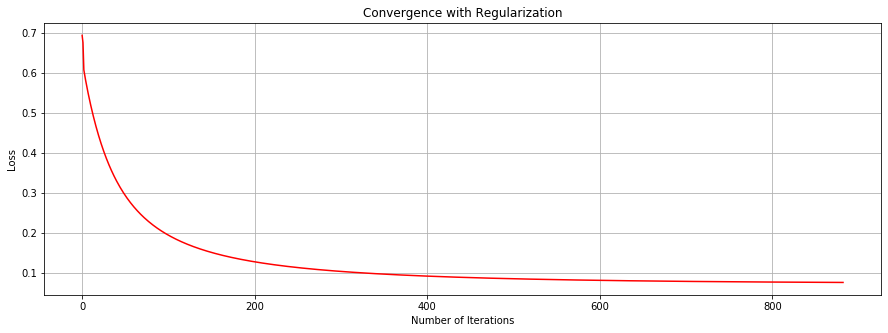

In [9]:
#Plot convergence with regularization
plot_convergence(training_loss_reg, "Convergence with Regularization")

5-fold cross validation is implemented to find the optimal $\lambda$ value. Training data are split into 5 folds of equal size. 4 groups are used to train the model, the remaining 1 group is used to evaluate the model. This procedure is repeated 5 times so that each fold can become the validation data. Results of 5 different values of $\lambda$ between 0 and 1 are compared (wit the constant learning rate of 0.1). The mean/std of cross validation accuracy of every parameter combination is reported as a table and the best configuration is selected. 

In [12]:
#Make the prediction
def predict(X, w_star):
    return X @ w_star

#Perform regularized logistic regression and compute accuracy
def compute_accuracy(y, X, w_star):
    prediction = predict(X, w_star)
    y_predict = np.where(prediction > 0 , 1, -1)
    correct = np.count_nonzero((np.equal(y,y_predict)))                            
    return correct / len(y)

def accuracy(acc, y, X, lambda_):
    w_star = log_regression(train_labels, X_train, 0.1, lambda_, False)
    w_star = np.array(w_star).reshape(3,1)
    accuracy = compute_accuracy(y, X, w_star)
    acc.append(accuracy)
    return acc

#Perform 5-fold cross validation and return 5 accuracies
def perform_cross_validation(X_folds, y_folds):
    acc_1, acc_2, acc_3, acc_4, acc_5 = [],[],[],[],[]
    
    for i in range(0,5):
        X_train = list(X_folds) 
        X_test = np.array(X_train.pop(i))
        X_train = np.concatenate(X_train)
    
        y_train = list(y_folds)
        y_test = np.array(y_train.pop(i))
        y_test.resize(len(y_test),1)
        y_train = np.concatenate(y_train) 
        y_train.resize(len(y_train),1)
        
        acc_1 = accuracy(acc_1, y_test, X_test, 0.05)
        acc_2 = accuracy(acc_2, y_test, X_test, 0.09)
        acc_3 = accuracy(acc_3, y_test, X_test, 0.1)
        acc_4 = accuracy(acc_4, y_test, X_test, 0.3)
        acc_5 = accuracy(acc_5, y_test, X_test, 0.6)
        
    acc_1 = np.array(acc_1)  
    acc_2 = np.array(acc_2)
    acc_3 = np.array(acc_3)
    acc_4 = np.array(acc_4)
    acc_5 = np.array(acc_5)
    
    return acc_1,acc_2,acc_3,acc_4,acc_5

In [ ]:
#Split the train data into 5 folds
X_folds = np.array_split(X_train, 5) 

#Split labels of train data into 5 folds
y_folds = np.array_split(train_labels, 5) 
 
#Perform 5-fold cross validation  and compute accuracies    
acc_1, acc_2, acc_3, acc_4, acc_5 = perform_cross_validation(X_folds, y_folds)

In [19]:
print(f"1st CV: Accuracy mean is {np.mean(acc_1)} and accuracy sd is {np.std(acc_1)} for lambda = 0.05 ")
print(f"2nd CV: Accuracy mean is {np.mean(acc_2)} and accuracy sd is {np.std(acc_2)} for lambda = 0.09 ")
print(f"3rd CV: Accuracy mean is {np.mean(acc_3)} and accuracy sd is {np.std(acc_3)} for lambda = 0.1 ")
print(f"4th CV: Accuracy mean is {np.mean(acc_4)} and accuracy sd is {np.std(acc_4)} for lambda = 0.3 ")
print(f"5th CV: Accuracy mean is {np.mean(acc_5)} and accuracy sd is {np.std(acc_5)} for lambda = 0.6 ")

1st CV: Accuracy mean is 0.9929569099696895 and accuracy sd is 0.005119007028211335 for lambda = 0.05 
2nd CV: Accuracy mean is 0.9903969034160728 and accuracy sd is 0.006061892790731425 for lambda = 0.09 
3rd CV: Accuracy mean is 0.98975792578029 and accuracy sd is 0.0071137142985568036 for lambda = 0.1 
4th CV: Accuracy mean is 0.9564512165151143 and accuracy sd is 0.02705953570485563 for lambda = 0.3 
5th CV: Accuracy mean is 0.8962501024002621 and accuracy sd is 0.06926093499110023 for lambda = 0.6 


Accuracy is the highest with the lambda = 0.05 for the learning rate 0.1

## Evaluation

Logistic regression classifier is trained with the learning rate 0.1. Training and test accuracy is computed by dividing the number of correctly classified samples to the total number of samples. 

Regularized logistic regression classifier is also trained with the learning rate 0.1 and lambda 0.05. Accuracy is computed by dividing the number of correctly classified samples to the total number of samples.

In [14]:
train_labels = train_labels.reshape(1561,1)
test_labels = test_labels.reshape(424,1)

#Accuracy without regularization
w_star = log_regression(train_labels, X_train, 0.1, 0, False)
training_acc = compute_accuracy(train_labels, X_train, w_star)
test_acc = compute_accuracy(test_labels, X_test, w_star)

#Accuracy with regularization
w_star_reg = log_regression(train_labels, X_train, 0.1, 0.05, False)
training_acc_reg = compute_accuracy(train_labels, X_train, w_star_reg)
test_acc_reg = compute_accuracy(test_labels, X_test, w_star_reg)

print(f"Training accuracy without regularization: {training_acc}")
print(f"Test accuracy without regularization: {test_acc}\n")

print(f"Training accuracy with regularization: {training_acc_reg}")
print(f"Test accuracy with regularization: {test_acc_reg}\n")

Training accuracy without regularization: 0.9974375400384369
Test accuracy without regularization: 0.9787735849056604

Training accuracy with regularization: 0.9929532351057014
Test accuracy with regularization: 0.9693396226415094



Our accuracy is 0.979. The training accuracy is close to the test accuracy, which is a sign that there is no overfitting. Also, regularization does not improve model performance for our data. 

To improve the test accuracy:
<ul>
<li>New data can be added.</li>
<li>Outliers and missing values (if exist) can be treated. </li>
<li>Other algorithms can be used along with logistic regression. 
(Dimensionality reduction, neural networks.)</li>
<li>Different values of lambdas and learning rates can be experimented. </li>
</ul>
